In [1]:
from __future__ import division
import pandas as pd
import numpy as np
from sklearn import preprocessing
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')
%matplotlib inline

## Part 1. Analysis of NFL data using Machine Learning

The New England Patriots have been the best team in the NFL over the last two decades, and Tom Brady, Patriots quarterback player has been the best player in the NFL over that time span. By using Machine Learning, we tried to predict the plays before they happen which will help strategize the defence scheme

In [2]:
NFL_data= pd.read_csv('/Users/shalinisingh/Desktop/Projects/NFL/NFL_Play_by_Play_2009-2018.csv', low_memory = False)

### Data Description

The play-by-play data from Kaggle contains details of all the games from 2009 through 2018 NFL seasons. For our project we took season data from 2014 to 2018 (~250MB data size). The dataset has 0.2 million rows and 255 columns. Observations reflect each play which contains detailed information on game situation, player involved, results, and advanced metrics such as expected point and win probability values.

In [3]:
NFL_data.shape

(224464, 255)

In [4]:
NFL_data.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,36,2014090400,SEA,GB,GB,away,SEA,SEA,35.0,9/4/2014,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,58,2014090400,SEA,GB,GB,away,SEA,GB,87.0,9/4/2014,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,79,2014090400,SEA,GB,GB,away,SEA,GB,81.0,9/4/2014,...,00-0026618,M.Bennett,5.0,0,NaN,Defensive Offside,0.0,0.0,0.0,0.0
3,111,2014090400,SEA,GB,GB,away,SEA,GB,76.0,9/4/2014,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,132,2014090400,SEA,GB,GB,away,SEA,GB,61.0,9/4/2014,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [5]:
# Convert the data column to datetime format so that we can compare
NFL_data['game_date'] = pd.to_datetime(NFL_data['game_date'])

In [6]:
NFL_data['play_type'].value_counts()

pass           93857
run            64736
no_play        21700
kickoff        12708
punt           11574
extra_point     5423
field_goal      4883
qb_kneel        1995
qb_spike         314
Name: play_type, dtype: int64

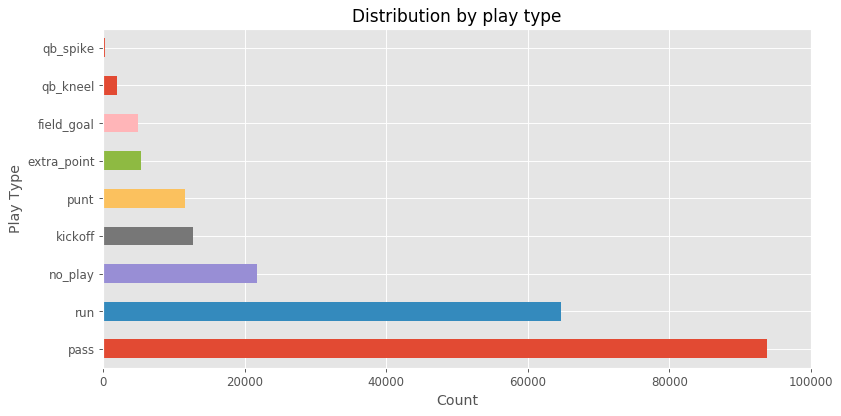

In [7]:
fig, ax = plt.subplots(figsize=(10, 5), dpi = 85)
f1 = NFL_data['play_type'].value_counts().plot(kind='barh') 
f1.set(title = "Distribution by play type", xlabel='Count', ylabel='Play Type')
f1.set_xlim(0,100000)
fig.tight_layout() 
plt.show()

### Predictive modeling based on 'play type' for New England Patriots

There are many fields that can help predict the plays, but we chose ‘play_type’ for our analysis. As the value we are trying to predict is represented by four columns which are dependent on ‘play_type’. We need to combine all these values into a single field.

In [8]:
# we are considering New Englanders with down not missing and play type either run or pass
ne_data = NFL_data[(NFL_data.posteam=='NE')  & (NFL_data.down.isin([1.0, 2.0, 3.0, 4.0])) & ((NFL_data.play_type=='run') | (NFL_data.play_type == 'pass'))]
len(ne_data)

5145

- Based on above plot, ‘run’ and ‘pass’ are most common play type. Hence, we combine ‘run’ and ‘pass’ with their location to get ‘full_play_type’. This variable was created as a combination of play_type, run_location (which way do the players run) and pass_location (which way do the players pass). If the play_type is “run” then run_location will be populated and pass location will be blank and otherwise for play_type as “pass”. By concatenating the play_type and run_location, pass_location accordingly, we created the dependent variable called full_play_type which consists of 6 categories- run_right, run_middle, run_left, pass_left, pass_middle, pass_right. The dependent variable was numerically encoded, and a new column was created ‘full_play_type_code’. 

In [9]:
# creating dependent variable by combinig play type, pass location and run location
def dep_var(play):
    play_type, pass_location, run_location = play
    if(play_type == 'run'):
        return play_type+'_'+ run_location
    else:
        return play_type+'_'+ pass_location
ne_data = ne_data.replace(np.nan, 'unknown', regex=True)
ne_data['full_play_type'] = ne_data[['play_type','pass_location', 'run_location']].apply(dep_var, axis=1)
ne_data = ne_data[(ne_data.full_play_type.isin(['pass_left', 'pass_middle','pass_right','run_left', 'run_middle', 'run_right']))]

In [10]:
# Since our goal is to predict the play type in a game we have selected the features to be used accordingly. 
# For the scope of this project we have restricted our features to 10 that we know are dependent on the play type as there are too many redundant variables.

# Filtering out the columns

ne_data = ne_data[['game_seconds_remaining', 'yardline_100', 'down', 'ydstogo', 'shotgun', 'score_differential', 'play_type', 'pass_length', 'pass_location', 'run_location', 'full_play_type']]

In [11]:
ne_data.head()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,play_type,pass_length,pass_location,run_location,full_play_type
1828,3600.0,80.0,1.0,10,0,0.0,run,unknown,unknown,middle,run_middle
1829,3569.0,78.0,2.0,8,0,0.0,pass,short,left,unknown,pass_left
1830,3532.0,74.0,3.0,4,1,0.0,pass,short,middle,unknown,pass_middle
1838,3406.0,80.0,1.0,10,0,-7.0,pass,short,middle,unknown,pass_middle
1839,3368.0,72.0,2.0,2,0,-7.0,pass,short,left,unknown,pass_left


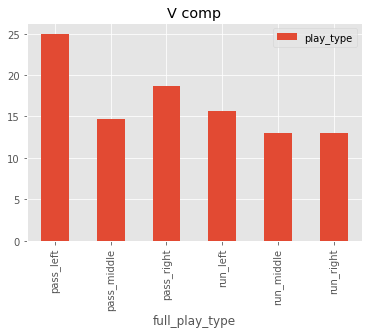

In [12]:
#Analyzing for potential patterns
ne_data.groupby(['full_play_type']).count()[['play_type']].apply(lambda x:100 * x / float(x.sum())).plot(kind='bar', title ="V comp")

- Normalized the features to have them in a uniform scale.

In [13]:
ne_data.groupby(['full_play_type']).count()[['play_type']].apply(lambda x:100 * x / float(x.sum()))

,play_type
full_play_type,
pass_left,25.010020
pass_middle,14.709419
pass_right,18.657315
run_left,15.671343
run_middle,12.985972
run_right,12.965932


In [14]:
#Converting dependent variable to numeric
le = preprocessing.LabelEncoder()
le.fit(ne_data.full_play_type)
ne_data['full_play_type_code'] = le.transform(ne_data['full_play_type'])

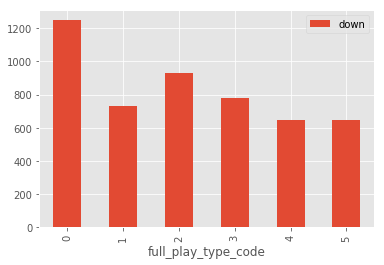

In [15]:
# Visualzing after transformation
ne_data.groupby(['full_play_type_code']).count()[['down']].plot(kind='bar')

In [16]:
#Creating dummy variables
def creating_dummyvar(val, size, count):
    i=0
    for i in range(count):
        if val <= (i+1)*size:
            return i
    return i
def dummy_df(df):
    df['ydstogo'] = [creating_dummyvar(x, 5, 5) for x in df['ydstogo']]
    return df
ne_data = dummy_df(ne_data)

In [17]:
ne_data = pd.concat([ne_data, pd.get_dummies(ne_data['down'], prefix='down')], axis=1)
ne_data = pd.concat([ne_data, pd.get_dummies(ne_data['ydstogo'], prefix='ydstogo')], axis=1)

In [18]:
ne_data.head()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,play_type,pass_length,pass_location,run_location,...,full_play_type_code,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0,ydstogo_1,ydstogo_2,ydstogo_3,ydstogo_4
1828,3600.0,80.0,1.0,1,0,0.0,run,unknown,unknown,middle,...,4,1,0,0,0,0,1,0,0,0
1829,3569.0,78.0,2.0,1,0,0.0,pass,short,left,unknown,...,0,0,1,0,0,0,1,0,0,0
1830,3532.0,74.0,3.0,0,1,0.0,pass,short,middle,unknown,...,1,0,0,1,0,1,0,0,0,0
1838,3406.0,80.0,1.0,1,0,-7.0,pass,short,middle,unknown,...,1,1,0,0,0,0,1,0,0,0
1839,3368.0,72.0,2.0,0,0,-7.0,pass,short,left,unknown,...,0,0,1,0,0,1,0,0,0,0


In [19]:
ne_data.describe()

,game_seconds_remaining,yardline_100,down,ydstogo,shotgun,score_differential,full_play_type_code,down_1.0,down_2.0,down_3.0,down_4.0,ydstogo_0,ydstogo_1,ydstogo_2,ydstogo_3,ydstogo_4
count,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4990.000000,4990.00000,4990.000000,4990.000000,4990.000000,4990.000000
mean,1796.797996,49.307214,1.762124,0.907615,0.507615,4.102605,2.158116,0.458717,0.333667,0.194389,0.013226,0.23487,0.669739,0.056914,0.029860,0.008617
std,1018.454458,25.199672,0.805951,0.693065,0.499992,10.231216,1.722259,0.498343,0.471570,0.395769,0.114255,0.42396,0.470354,0.231701,0.170217,0.092437
min,3.000000,1.000000,1.000000,0.000000,0.000000,-33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,927.250000,29.000000,1.000000,1.000000,0.000000,-1.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1822.500000,52.000000,2.000000,1.000000,1.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000
75%,2661.750000,71.000000,2.000000,1.000000,1.000000,10.000000,4.000000,1.000000,1.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000
max,3600.000000,99.000000,4.000000,4.000000,1.000000,38.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [20]:
# Normalizing the features

ne_data['game_seconds_remaining']/=3600
ne_data['yardline_100']/=100
ne_data['score_differential']=(ne_data['score_differential']+50)/100

In [21]:
#select important columns for input
X=ne_data[['yardline_100', 'shotgun', 'score_differential', 'game_seconds_remaining', 'down_1.0', 'down_2.0', 'down_3.0', 
        'down_4.0','ydstogo_0','ydstogo_1','ydstogo_2','ydstogo_3','ydstogo_4']]
#select result column for output
Y=ne_data['full_play_type_code']

### Predictive Modeling

In [22]:
#split data for train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.25, random_state = 123)

#### 1. Random Forest

In [23]:
model1=RandomForestClassifier(max_depth=8, n_estimators=64)
model1.fit(X_train, y_train)
pred = model1.predict(X_test)

In [24]:
print(metrics.classification_report(y_test, pred))
print("Accuracy of the model=",metrics.accuracy_score(y_test, pred))

              precision    recall  f1-score   support

           0       0.34      0.69      0.46       321
           1       0.19      0.05      0.07       198
           2       0.38      0.08      0.13       251
           3       0.27      0.48      0.35       190
           4       0.29      0.17      0.21       141
           5       0.27      0.16      0.20       147

   micro avg       0.31      0.31      0.31      1248
   macro avg       0.29      0.27      0.24      1248
weighted avg       0.30      0.31      0.26      1248

Accuracy of the model= 0.3108974358974359


In [27]:
pred = model1.predict(X_test)
acc =accuracy_score(y_test, pred)
print(acc)

0.3108974358974359


#### 2. Naive Bayes

In [28]:
nb = MultinomialNB()
# Train the model
nb.fit(X_train, y_train)
# Take the model that was trained on the X_train_cv data and apply it to the X_test_cv data
y_pred = nb.predict(X_test)

In [29]:
metrics.accuracy_score(y_test, y_pred)

0.3020833333333333

In [105]:
print(metrics.classification_report(y_test, y_pred))
print("Accuracy of the model=",metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.75      0.44       321
           1       0.28      0.07      0.11       198
           2       0.00      0.00      0.00       251
           3       0.30      0.52      0.38       190
           4       0.26      0.18      0.21       141
           5       0.00      0.00      0.00       147

   micro avg       0.30      0.30      0.30      1248
   macro avg       0.19      0.25      0.19      1248
weighted avg       0.20      0.30      0.21      1248

Accuracy of the model= 0.3020833333333333


C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jeyen\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Conclusion: After running the models, we were able to achieve an accuracy of 30% which clearly shows that prediction of the next play using Machine Learning works better than random guessing or applying simple averaging technique.

## Part 2. The Garoppolo Effect

In October 2017, Jimmy Garoppolo was traded by the New England Patriots to the San Francisco 49ers. He played 5 games for them after being traded mid-season and led the 49ers to wins in all those games. It is said to be the biggest trade in the NFL history. The aim is to study the effect that 49ers; new quarterback Jimmy Garoppolo had on the 49ers’ offense during the 2017 season, known as the Garoppolo effect.

- We will just using 49ers data (where home or away team is 49ers) for the 2017 season. 

In [30]:
# Subsetting the data for the season 2017-2018
g = NFL_data[ (NFL_data['game_date']>=pd.datetime(2017,9,1)) & (NFL_data['game_date']<=pd.datetime(2018,3,1))]

- Missing Values

In [31]:
# get the number of missing data points per column
missing_value_count = NFL_data.isnull().sum()
missing_value_count

play_id                               0
game_id                               0
home_team                             0
away_team                             0
posteam                            7469
posteam_type                       7274
defteam                            7274
side_of_field                       330
yardline_100                       7368
game_date                             0
quarter_seconds_remaining            81
half_seconds_remaining              105
game_seconds_remaining              103
game_half                             0
quarter_end                           0
drive                                 0
sp                                    0
qtr                                   0
down                              34864
goal_to_go                         7173
time                                 81
yrdln                               330
ydstogo                               0
ydsnet                                0
desc                                  0


In [32]:
# how many total missing values we have?
total_cells = np.product(NFL_data.shape)
total_missing = missing_value_count.sum()
total_missing

22122738

In [33]:
# percent of data that is missing
(total_missing/total_cells)*100

38.650222438394415

In [34]:
# replace all NA's with the value that comes directly after it in the same column
NFL_data = NFL_data.fillna(method='bfill', axis=0).fillna(0)

- Adding an additional column called ‘Jimmy’ that is yes if the game date is on or after December 3rd, 2017 and is no otherwise.

In [35]:
# Create a new column 'Jimmy' that is yes if the 'game_date' is on or after December 3rd, 2017 and no otherwise.
g['Jimmy'] = np.where(g['game_date']>=pd.datetime(2017,12,3), 'yes', 'no')

In [36]:
# San Fransisco 49ers specific data such that home or away team is the SF 49ers.
g_niners = g[(g['home_team'] == 'SF') | (g['away_team'] == 'SF')]

#### - Number of Touchdowns

In [37]:
# home or away team being 'SF', a scoring play occurred, a touchdown occurred, the team on offense was 'SF'
g_niners_td = g[(((g['home_team'] == 'SF') | (g['away_team'] == 'SF')) & (g['sp'] == 1) & (g['touchdown'] ==1) & (g['defteam'] != 'SF'))]

In [41]:
# check how many touchdowns were scored without Jimmy and with him by subsetting our dataframe.
print ("Touchdowns scored without Jimmy:" , len(g_niners_td[g_niners_td['Jimmy']== 'no']))
print ("Touchdowns scored with Jimmy:" , len(g_niners_td[g_niners_td['Jimmy']== 'yes']))

Touchdowns scored without Jimmy: 19
Touchdowns scored with Jimmy: 13


In [42]:
# graph the number of touchdowns scored while Jimmy started and did not start games.
tds = g_niners_td.groupby('Jimmy').touchdown.sum()

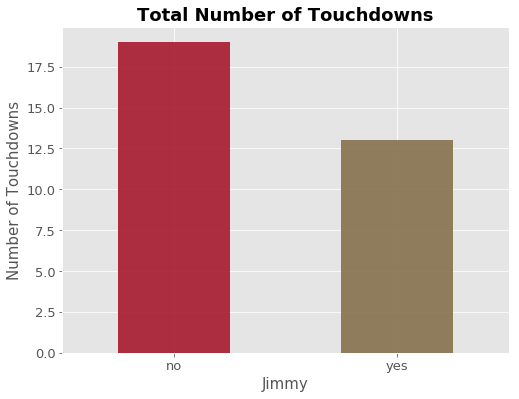

In [44]:
fig, ax = plt.subplots(figsize=(8, 6), dpi = 72)
ax.set_title("Total Number of Touchdowns", fontsize = 18, fontweight = 'bold') # Chart title
ax.set_xlabel('Jimmy', fontsize = 15) # X-axis label
ax.set_ylabel('Number of Touchdowns', fontsize = 15) # Y-axis label
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

mycolors = ['#A6192E', '#85714D'] # Using scarlet and gold colors

tds.plot(kind='bar', alpha = 0.9, rot=0, color = mycolors) # Plot a Bar chart
plt.show()

- Although, touchdowns with Jimmy looks lower but he played in only 5 games. So let's check touchdowns per game

In [45]:
# get the unique number of games Jimmy did not play in
pre_jimmy = len( g_niners[g_niners['Jimmy'] == 'no']['game_id'].unique() )
print (pre_jimmy)

11


In [46]:
# get the unique number of games that Jimmy did play in
post_jimmy = len( g_niners[g_niners['Jimmy'] == 'yes']['game_id'].unique() )
print (post_jimmy)

5


In [48]:
print ("Before Jimmy, touchdowns per game was %.2f" % (19/pre_jimmy))
print ("After Jimmy, touchdowns per game was %.2f" % (13/post_jimmy))

Before Jimmy, touchdowns per game was 1.73
After Jimmy, touchdowns per game was 2.60


#### - Touchdowns and Interceptions over Time

In [49]:
# sum of touchdowns by game day
td_by_date = g_niners.groupby('game_date')['touchdown'].sum()
td_by_date

game_date
2017-09-10     2.0
2017-09-17     1.0
2017-09-21    10.0
2017-10-01     1.0
2017-10-08     4.0
2017-10-15     6.0
2017-10-22     7.0
2017-10-29     5.0
2017-11-05     3.0
2017-11-12     6.0
2017-11-26     4.0
2017-12-03     2.0
2017-12-10     4.0
2017-12-17     3.0
2017-12-24    10.0
2017-12-31     5.0
Name: touchdown, dtype: float64

In [50]:
# sum of interceptions by game day
interc_by_date = g_niners.groupby('game_date')['interception'].sum()
interc_by_date

game_date
2017-09-10    2.0
2017-09-17    1.0
2017-09-21    1.0
2017-10-01    2.0
2017-10-08    1.0
2017-10-15    2.0
2017-10-22    0.0
2017-10-29    3.0
2017-11-05    2.0
2017-11-12    1.0
2017-11-26    2.0
2017-12-03    1.0
2017-12-10    1.0
2017-12-17    0.0
2017-12-24    4.0
2017-12-31    2.0
Name: interception, dtype: float64

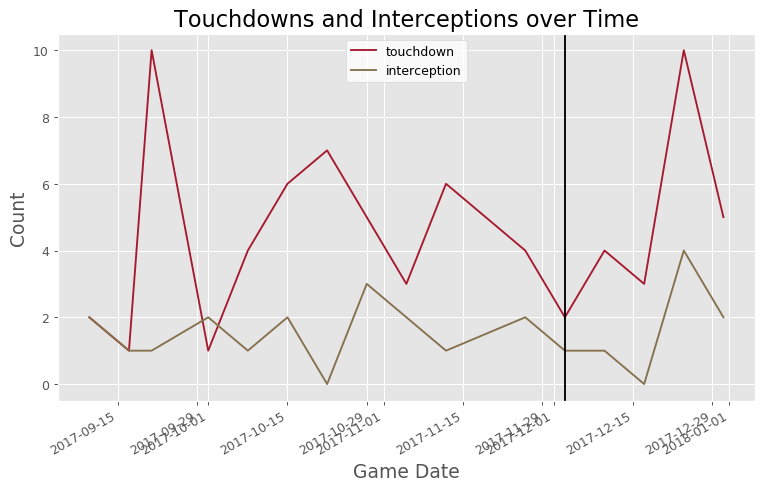

In [51]:
fig, ax = plt.subplots(figsize=(10, 6), dpi = 90) # set plot size 

mycolors = ['#A6192E', '#85714D'] # Using scarlet and gold colors

f1 = td_by_date.plot(color = mycolors[0]) # plot the touchdowns
f2 = interc_by_date.plot(color = mycolors[1]) # plot the interceptions

ax.set_title("Touchdowns and Interceptions over Time", fontsize = 18) # Chart title
ax.set_xlabel('Game Date', fontsize = 15) # X-axis label
ax.set_ylabel('Count', fontsize = 15) # Y-axis label
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.axvline(dt.datetime(2017, 12, 3), color = 'black') # add a vertical line
plt.legend(loc='upper center', frameon=True, facecolor="white") # add a legend with a white background

plt.show()

#### The lines to the right of the black vertical line are games that Jimmy played. We notice that before he started for the 49ers, the team was on a downward trend and after he started, their offense started taking off again.

In [52]:
p1 = g_niners[g_niners['Jimmy']=='no']['play_type'].value_counts() 
p2 = g_niners[g_niners['Jimmy']=='yes']['play_type'].value_counts()

In [53]:
p1

pass           856
run            602
no_play        196
kickoff        113
punt           112
field_goal      50
extra_point     44
qb_kneel        22
qb_spike         2
Name: play_type, dtype: int64

In [54]:
a = p1/pre_jimmy
b = p2/post_jimmy

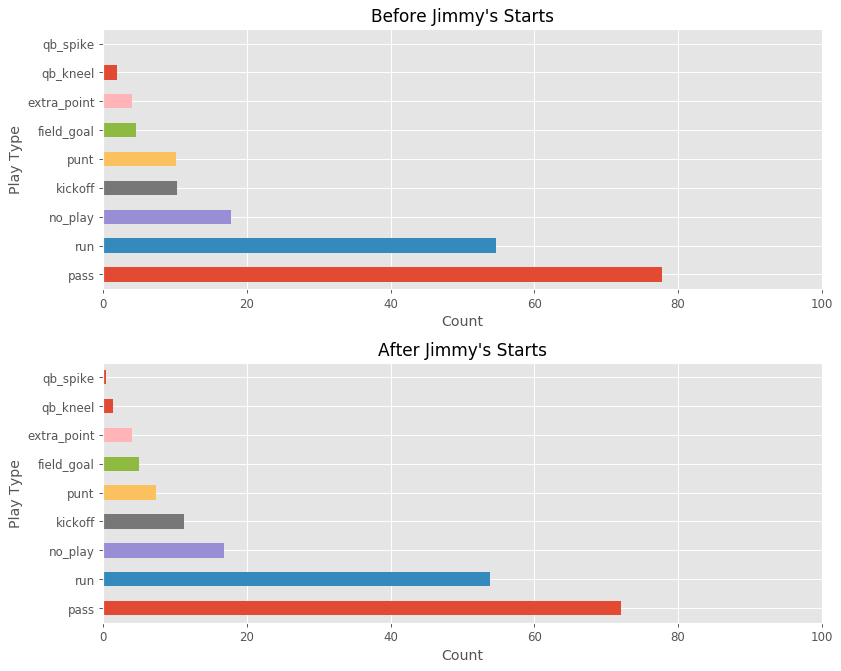

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), dpi = 85) # specify a plot with 2 rows and 1 column

# get plays where Jimmy did not start and did start
f1 = a.plot(kind='barh', ax=ax[0]) 
f2 = b.plot(kind='barh', ax=ax[1])

f1.set(title = "Before Jimmy's Starts", xlabel='Count', ylabel='Play Type')
f2.set(title = "After Jimmy's Starts", xlabel='Count', ylabel='Play Type')
f1.set_xlim(0,100)
f2.set_xlim(0,100)
fig.tight_layout() # prevent overlapping axis labels

plt.show()

#### Conclusion: In 2016 season we saw 49ers were near bottom of the league. Whereas, in 2017 the Niners drastically improved and finished the season in top half and for this quarterback Jimmy Garoppolo deserves most of the credit.